# OpenPose vs OpenPose Mobile

In [1]:
import tensorflow as tf

In [2]:
from tensorflow.core.framework import graph_pb2

### Load OpenPose graph (with VGG)

In [3]:
tf.reset_default_graph()

In [4]:
openpose_vgg_graph = tf.Graph()

In [5]:
graph_openpose_vgg_def = graph_pb2.GraphDef()
with open("models/openpose_vgg_opt.pb", "rb") as f:
    graph_openpose_vgg_def.ParseFromString(f.read())

In [6]:
with openpose_vgg_graph.as_default():
    tf.import_graph_def(graph_openpose_vgg_def, name="")
    
    input_vgg = openpose_vgg_graph.get_tensor_by_name("inputs:0")
    
    heatmaps_vgg_by_stage = []
    pafs_vgg_by_stage = []
    for stage_idx in range(2, 7):
        heatmaps_vgg_by_stage.append(openpose_vgg_graph.get_tensor_by_name("Mconv7_stage{}_L2/BiasAdd:0".format(stage_idx)))
        pafs_vgg_by_stage.append(openpose_vgg_graph.get_tensor_by_name("Mconv7_stage{}_L1/BiasAdd:0".format(stage_idx)))

### Load MobileNet OpenPose graph

In [7]:
tf.reset_default_graph()

In [8]:
openpose_mobile_graph = tf.Graph()

In [9]:
graph_openpose_mobile_def = graph_pb2.GraphDef()
with open("models/openpose_mobile_opt.pb", "rb") as f:
    graph_openpose_mobile_def.ParseFromString(f.read())

In [10]:
with openpose_mobile_graph.as_default():
    tf.import_graph_def(graph_openpose_mobile_def, name="")
    
    input_mobile = openpose_mobile_graph.get_tensor_by_name("image:0")
    
    heatmaps_mobile_by_stage = []
    pafs_mobile_by_stage = []
    for stage_idx in range(2, 7):
        heatmaps_mobile_by_stage.append(openpose_mobile_graph.get_tensor_by_name("Openpose/MConv_Stage{}_L2_5_pointwise/BatchNorm/FusedBatchNorm:0".format(stage_idx)))
        pafs_mobile_by_stage.append(openpose_mobile_graph.get_tensor_by_name("Openpose/MConv_Stage{}_L1_5_pointwise/BatchNorm/FusedBatchNorm:0".format(stage_idx)))

### All tensors combined

In [11]:
graphs = {
    "vgg": openpose_vgg_graph,
    "mobile": openpose_mobile_graph
}

In [12]:
input_tensors = {
    "vgg": input_vgg,
    "mobile": input_mobile
}

heatmaps_tensors = {
    "vgg": heatmaps_vgg_by_stage,
    "mobile": heatmaps_mobile_by_stage
}

pafs_tensors = {
    "vgg": pafs_vgg_by_stage,
    "mobile": pafs_mobile_by_stage
}

In [13]:
tensors = {
    "inputs": input_tensors,
    "heatmaps": heatmaps_tensors,
    "pafs": pafs_tensors
}

### Image helper function

In [14]:
#from __future__ import division
import numpy as np
import matplotlib.pyplot as plt
import cv2
import time

In [15]:
def load_image(path):
    img = cv2.imread(path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    return img

In [16]:
def adapt_image(img, k=1.):
    h, w = img.shape[:2]
    
    new_h = int(k*h)
    new_w = int(k*w)
    
    res_img = cv2.resize(img, (new_w, new_h))
    res_img = res_img.reshape([1, new_h, new_w, 3])
    prep_img = res_img*(2/255.0) - 1
    
    return res_img, prep_img

In [17]:
def draw_part_heatmap(img, heatmaps, part_idx):
    part_heatmap = heatmaps[0, :, :, part_idx]
    part_heatmap_reshaped = cv2.resize(part_heatmap, (img.shape[1], img.shape[0]))
    
    plt.imshow(img)
    part_heatmap_plot = plt.imshow(part_heatmap_reshaped, 'magma', alpha=.6)
    plt.colorbar(part_heatmap_plot)
    plt.show()

In [18]:
image_test = load_image('data/test.jpg')
res_image_test, prep_image_test = adapt_image(image_test)

Shape: (400, 600, 3)


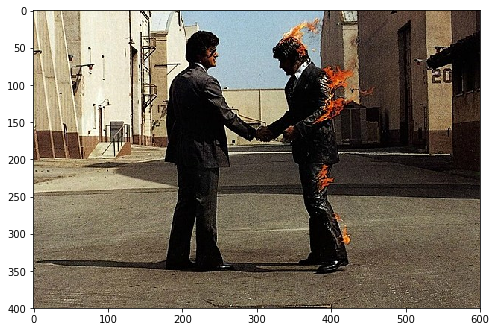

In [19]:
print "Shape: {}".format(image_test.shape)

plt.figure(figsize=(8, 8))
plt.imshow(image_test);

In [20]:
image = {
    "original": image_test,
    "vgg": prep_image_test,
    "mobile": res_image_test
}

## Comparison

In [21]:
from ipywidgets import interact, fixed

In [22]:
class OpenPoseTesting():
    def __init__(self, image):
        self.image = image
        self.heatmaps = np.zeros_like(image)
        
    def adapt_image(self, k=1.):
        h, w = self.image["original"].shape[:2]

        new_h = int(k*h)
        new_w = int(k*w)

        res_img = cv2.resize(self.image["original"], (new_w, new_h))
        res_img = res_img.reshape([1, new_h, new_w, 3])
        prep_img = res_img*(2/255.0) - 1

        self.image["vgg"] = prep_img
        self.image["mobile"] = res_img
        

    def draw_part_heatmap(self, part_idx):
        part_heatmap = self.heatmaps[0, :, :, part_idx]
        
        h, w = self.image["original"].shape[:2]
        part_heatmap_reshaped = cv2.resize(part_heatmap, (w, h))

        plt.figure(figsize=(8, 8))
        plt.imshow(self.image["original"])
        part_heatmap_plot = plt.imshow(part_heatmap_reshaped, 'magma', alpha=.6)
        plt.colorbar(part_heatmap_plot, fraction=0.031)
        plt.show()
        

    def inference(self, forward_pass, graph, k, stage_idx, part_idx, tensor, direction):

        if forward_pass:
            if k != 1.: self.adapt_image(k)

            with tf.Session(graph=graphs[graph]) as sess:
                t = time.time()

                self.heatmaps = sess.run(tensors[tensor][graph][stage_idx-2], feed_dict={
                    tensors["inputs"][graph]: self.image[graph]
                })

                print "Inference time: {:.4f}".format(time.time() - t)
                print "Output shape: {}".format(self.heatmaps.shape[1:3])

        if tensor=='heatmaps':
            jump_part = lambda part_idx: part_idx
        elif direction=='x':
            jump_part = lambda part_idx: 2*part_idx
        elif direction=='y':
            jump_part = lambda part_idx: 2*part_idx + 1
            
        self.draw_part_heatmap(jump_part(part_idx))

In [23]:
op = OpenPoseTesting(image)

In [24]:
interact(op.inference,
         forward_pass=True,
         graph=["vgg", "mobile"],
         k=(0, 2, 0.1),
         stage_idx=(2, 6),
         part_idx=(0, 18),
         tensor=["heatmaps", 'pafs'],
         direction=['x', 'y']
        );

interactive(children=(Checkbox(value=True, description=u'forward_pass'), Dropdown(description=u'graph', options=('vgg', 'mobile'), value='vgg'), FloatSlider(value=1.0, description=u'k', max=2.0), IntSlider(value=4, description=u'stage_idx', max=6, min=2), IntSlider(value=9, description=u'part_idx', max=18), Dropdown(description=u'tensor', options=('heatmaps', 'pafs'), value='heatmaps'), Dropdown(description=u'direction', options=('x', 'y'), value='x'), Output()), _dom_classes=('widget-interact',))